# Using signature methods to find anomalies in flight data 

## Maud Lemercier, Varun Chhabra, Dmitry Filippov
### Corresponding slides - https://docs.google.com/presentation/d/e/2PACX-1vQR8GlAYiySySjQk9DzRJV1BwtD0Mn01-nsLbiENxam6gRRJuIJO86rXgbcAkgSOMcXGJO-qsQOGFds/pub?start=false&loop=true&delayms=30000

This notebook demostrates a way to convert temporal graph data of flights into a time series that can be analysed using signature methods.

We aim to achieve 2 goals:

- To be able to identify 2 clusters of dates - ones before and after UK lockdown based on flight data across largest UK airports
- To be able to detect anomalies in flight data in the middle east related to Russian involvment in Libyan civil war

To achieve these goals, we will be splitting the time series of airplane flights into small chunks of approximately 1 week and identifying each one as either anomalous or not. To do that, we convert the information stored in the flight data into a fixed dimensional path and use path signature as it's vector representaion.



In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import esig
import numpy as np
import random
import matplotlib.pyplot as plt
import itertools
import zipfile
import pickle
import iisignature
import sqlite3
import ruptures as rpt
from datetime import datetime

import sys
sys.path.append("..")
from signature_calculation import calculate_signatures
from path_calculation import construct_paths
from path_calculation import construct_single_path_edges
from path_calculation import construct_single_path_vertices

import outlier_calc
import clustering

from variance import variance

day = 86400
LOCKDOWN_SIGNATURES_PATH = 'signatures/key.pkl'
CONFLICT_SIGNATURES_PATH = 'signatures1/key.pkl'
DUMMY_SIGNATURES_PATH = 'dummy_signatures/key.pkl'
DUMMY_SIGNATURES_PATH2 = 'dummy_signatures/2_key.pkl'
DUMMY_CLEAN_SIGNATURES_PATH = 'dummy_signatures/key_clean.pkl'

### Hyperparameters class

This class is used to give all the functions model hyperparameters. The parameters represent:

 - Normalising_data: indicates if the stream should be normalised before calculating signature (centred at 0 and having variance 1)
 - Scale_data: indicated if the stream should be scaled before calculating signature -divided by a scalar to have absolute value below 1. Should be mutually exclusive with normalising_data
 - Preprocess_data_columnwise: if set to false, the entire stream is scaled/normalised as one (except time variables), if set to true each dimension is scaled/normalised sepparately.
 - normalising_singature / scalle_singature: similar but for signature vector
 - Covariance_method: Emptirical vs robust covariance matrix estimate
 - knn_metric: metric used in k nearest neighbours algorithm. Mahalanobis metric uses covariance estimate to calculate number of standard deviation of a given point from main distribution
 - observed:  the observed airport's icao identifiers
 - depth: the depth of a signature
 - time_variable: indicates whether or not time is included as a dimension in the stream
 - daytime_variable: indicates whether time modulo 86400 (time of day) is included in the stream
 - stream_length: the length of observed substreams
 - stream_spacing: the separation of substreams from each other (substreams interleave to produce more data)
 - mode: whether vertex or edge method is used to calculate streams
 - extrapollation: indicates if the stream is extrapollated between points. There is a mathematical reason to believe that a more rectangular stream with sharp changes in variables is better at picking up order of events when converted to signature
 - lead_lag: whether lead-lag transformation is applied to the stream
 - neighbours: number of neighbours in knn algorithm

In [2]:
class hyperparameters:
    normalising_data = False
    scale_data = False
    preprocess_data_columnwise = False
    normalising_signature = False
    scale_signature = False
    covariance_method = "Emperical"
    knn_metric = 'minkowski'
    observed = tuple(["EGLL", "EGCC", "EGPF", "EGPH", "EGKK"])
    depth = 2
    time_variable = True
    daytime_variable = True
    stream_length = 7 * day
    stream_spacing = 2 * day

    mode = "vertices"
    
    extrapollation = False
    lead_lag = False
    directional_edges = True

    neighbours = 5
 

# Methodology 





## Data used

We use 2 types of data:

- First kind is the records of all airplane flights in the period between june 2019 and 2021
- Second kind is the dummy data, generated together with anomalies as the means to test anomaly detection algorithm imperically

### Real world data
The data is presented as follows:

In [3]:
query = ''' SELECT *
            FROM Flights
            LIMIT 5'''
conn = sqlite3.connect("file:flights.db?nolock=1", uri=True)
events = pd.read_sql_query(query, conn)
conn.close()
print(events) 

  address  altitude callsign        date destination_iata destination_icao  \
0  000000         0  RA78039  2019-06-10             None             None   
1  000000         0  RA78039  2019-06-25             None             None   
2  5153AD         0     HKYO  2019-06-08             None             None   
3  000000     39875     GLEX  2019-06-01             None             ZBAA   
4  000000         0     GLEX  2019-06-01             None             ZBAA   

  equipment           event   flight  flight_id  latitude  longitude operator  \
0      None  gate_departure  RA78039  547322955   59.8048    30.2531     None   
1      None  gate_departure  RA78039  547322955   59.8048    30.2531     None   
2      GRND  gate_departure     None  547323363   38.5831    68.8157     None   
3      GLEX         descent     None  548767257   61.8015    29.3968     None   
4      GLEX          landed     None  548767257   60.3155    24.9797     None   

  origin_iata origin_icao registration      

The construct_path package works with series of events of the form ["Airport ID", "timestamp", "takeoff/landed", "flight id"], so we use SQL query to get the data we need and convert it to the needed format using pandas.

In [4]:
query= '''SELECT origin_icao, date, time, event, flight_id 
          FROM Flights
          WHERE destination_icao IN {} AND origin_icao IN {} AND event = 'takeoff' 
          UNION
          SELECT destination_icao, date, time, event, flight_id 
          FROM Flights
          WHERE destination_icao IN {} AND origin_icao IN {} AND event = 'landed' '''.format(*([hyperparameters.observed] * 4) )


conn = sqlite3.connect("file:flights.db?nolock=1", uri=True)
events = pd.read_sql_query(query, conn)
conn.close()


def datetime_convert(row):
    date = row['date']
    time = row['time']
    date = date[2:]
    date_time = date + " " + time
    date_time_obj = datetime.strptime(date_time, '%y-%m-%d %H:%M:%S')
    return int(round(date_time_obj.timestamp()))

events['timestamp'] = events.apply(lambda row: datetime_convert(row), axis = 1)
events = events[['origin_icao', 'timestamp', "event", "flight_id"]]
events = events.rename(columns = {'origin_icao': 'icao'})
events = events.rename(columns = {'flight_id': 'id'})

events = events.sort_values("timestamp")


### Generating dummy data

Dummy data has 3 types of anomalies: 
- Flight chaining anomalies
- Unusual flight rates between select airports
- Flights occurring in clusters rather than being uniformly spread


In [5]:
from generator import generate_data
generate_data()

dummy_clean_events = pd.read_csv('clean_data.csv')
dummy_anomalous_events_labels = pd.read_csv('data_anomaly_labels.csv')
dummy_anomalous_IDs = set(dummy_anomalous_events_labels['id'].values.tolist())
dummy_events = pd.read_csv('data.csv')

## Anomaly detection



We focus on converting temporal graph data into a fixed dimansional time series while retaining valuable information about order of events. For the purposes of this notebook we will be splitting stream into fixed length substreams and identifying those as anomalous, however it is theoretically possible to use anomaly detection on the stream itself. Primary focus of this methodology is to detect unusual and potentially malicious activity in observed regions, such as military troop transfers; this methodology however could also be used for classification - either classifying nodes (one example  would be detecting hub airports) or time periods (detecting change related to covid restrictions).

We will consider the original graph to have timed edges, which could also be thought of as messages being passed between pairs of nodes. In case of flight data, an edge between nodes A and B lasting between time x and y represents an airplane which departs from A at time x and arrives at B at time y. There are 2 natural ways to represent this data as a time series - vertex focused and edge focused. =

In **vertex** case, we consider arrivals and departures at a given node as 2 sepparate dimensions and keep cumulative counts of each. This approach uses 2n dimensions where n is the number of vertices, but looses the information connecting arrivals and departures as 2 endpoints of the same event. It is potentially valuable when observing large subgraphs and when interactions of flights at an airport are more important than more global topological properties (e.g. when trying to detect chaining of flights).

In **edge** case, we consider each edge (pair of airports) as a dimension and record number of flights between airports at any given time. This could either be encoded in the same dimension, with one direction being negative and other positive or in 2 dimensions if there are often flights in both directions at the same time. Downside of this method is that it uses O(n^2) dimensions. It does, however, retain more information. There is also less connection between flights arriving/departing at the same airport as one airport has data present in multiple dimensions. 

After obtaining the substreams, we will be using path signatures (see https://github.com/pafoster/path_signatures_introduction) as a vectorisation of that data. Path signatures are uniquely fitted to deal with this sort of data, as potential anomalous activity is very sensitive to order of events.

One dimension of edge path against time:

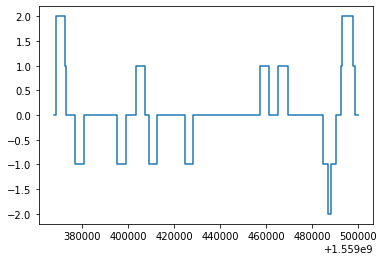

In [10]:
path = construct_single_path_edges(events, hyperparameters)
plt.plot([path[i][-1] for i in range(500)], [path[i][2] for i in range(500)])
plt.show()

One dimension of vertex path against time:

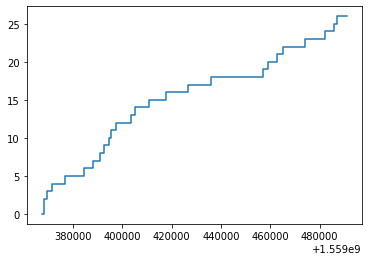

In [11]:
path = construct_single_path_vertices(events, hyperparameters)
plt.plot([path[i][-1] for i in range(500)], [path[i][5] for i in range(500)])
plt.show()

### 

# Splitting data into substreams and calculating their signatures across different hyperparameters

We save signatures of subpaths for each relevant combination of hyperparameters as pickle files for use later.

In [12]:
def calculate_signatures_by_hyperparameters(events, SIGNATURES_PATH, anomalous_IDs = []):
    print("calculating signatures")
    for stream_spacing in [3]:
        for stream_length in [10]:
            for scaling in [True, False]:
                hyperparameters.scale_data = scaling
                hyperparameters.stream_spacing = stream_spacing * day
                hyperparameters.stream_length = stream_length * day
                for mode in ["edges", "vertices"]:
                    for param_combination in itertools.product(*([[False, True]] * 3)):          
                        hyperparameters.mode = mode
                        hyperparameters.daytime_variable = param_combination[0]
                        hyperparameters.time_variable = param_combination[1]            
                        hyperparameters.extrapollation = param_combination[2]
                        key = 'LeadLag=False, Daytime={}, Time={}, Extrapollation={}'.format(*param_combination)+ ', Data Scaling={}'.format(scaling) + ', Length=' + str(stream_length) + ', Spacing = ' + str(stream_spacing) + ', Mode = ' + mode 
                        print('.', end='')   
                        if mode == "vertices":
                            streams, anomaly_count, timestamps = construct_paths(events, anomalous_IDs, hyperparameters)
                            streams = streams[1:-6]
                            anomaly_count = anomaly_count[1:-6]
                            timestamps = timestamps[1:-6]
                            labels = [anomaly_count[i] > 0 for i in range(len(anomaly_count))]
                            with open(SIGNATURES_PATH.replace('key', key + " TIMESTAMPS"), 'wb') as f:
                                    pickle.dump(timestamps, f)
                            with open(SIGNATURES_PATH.replace('key', key + " STREAMS"), 'wb') as f:
                                    pickle.dump(streams, f)      
                            if anomalous_IDs:
                                with open(SIGNATURES_PATH.replace('key', key + ' LABELS'), 'wb') as f:
                                    pickle.dump(labels, f)  
                            for depth in [2, 3]:  
                                key_ = key + ', Depth = ' + str(depth)
                                hyperparameters.depth = depth   
                                streams_signatures = calculate_signatures(streams, hyperparameters)
                                with open(SIGNATURES_PATH.replace('key', key_), 'wb') as f:
                                    pickle.dump(streams_signatures, f)
                        else:
                            for directional_edges in [True, False]:
                                hyperparameters.directional_edges = directional_edges
                                key_ = key + ', Directional_edges = {}'.format(directional_edges)
                                streams, anomaly_count, timestamps = construct_paths(events, anomalous_IDs, hyperparameters)
                                streams = streams[1:-6]
                                anomaly_count = anomaly_count[1:-6]
                                timestamps = timestamps[1:-6]
                                labels = [anomaly_count[i] > 0 for i in range(len(anomaly_count))]
                                with open(SIGNATURES_PATH.replace('key', key_ + " TIMESTAMPS"), 'wb') as f:
                                    pickle.dump(timestamps, f)
                                with open(SIGNATURES_PATH.replace('key', key_ + " STREAMS"), 'wb') as f:
                                    pickle.dump(streams, f)  
                                if anomalous_IDs:
                                    with open(SIGNATURES_PATH.replace('key', key_ + ' LABELS'), 'wb') as f:
                                        pickle.dump(labels, f)    
                                for depth in [2, 3]:  
                                    key__ = key_ + ', Depth = ' + str(depth)
                                    hyperparameters.depth = depth   
                                    streams_signatures = calculate_signatures(streams, hyperparameters)
                                    with open(SIGNATURES_PATH.replace('key', key__), 'wb') as f:
                                        pickle.dump(streams_signatures, f)
                                      

# Clustering of UK airport flight data

We first calculate signatures for 5 biggest UK Airports and then try to cluster them using k-means algorithm


In [13]:
hyperparameters.observed = tuple(["EGLL", "EGCC", "EGPF", "EGPH", "EGKK"])
calculate_signatures_by_hyperparameters(events, LOCKDOWN_SIGNATURES_PATH)

calculating signatures
................................

In [14]:
lockdown_labels_vs_hyperparameters = {}
lockdown_timestamps_vs_hyperparameters = {}
for stream_spacing in [3]:
    for stream_length in [10, 20]:
        hyperkey = ', Length=' + str(stream_length) + ', Spacing = '+ str(stream_spacing) 
        labels = {}
        timestamps = {}
        for scaling in [True, False]:
            
            for mode in ["edges", "vertices"]:
                for param_combination in itertools.product(*([[False, True]] * 3)): 
                    if mode == "vertices":
                        timestamps_key = 'LeadLag=False, Daytime={}, Time={}, Extrapollation={}'.format(*param_combination)+', Data Scaling={}'.format(scaling) + hyperkey  + ', Mode = ' + mode
                        for depth in [2, 3]:
                            file_key = timestamps_key + ', Depth = ' + str(depth)
                            key = 'LeadLag=False, Daytime={}, Time={}, Extrapollation={}'.format(*param_combination)+', Data Scaling={}'.format(scaling)+ ', Mode = ' + mode + ', Depth = ' + str(depth)
                            with open(LOCKDOWN_SIGNATURES_PATH.replace('key', timestamps_key + " TIMESTAMPS"), 'rb') as f_timestamps:
                                with open(LOCKDOWN_SIGNATURES_PATH.replace('key', file_key), 'rb') as f_signatures:
                                    signatures = pickle.load(f_signatures)
                                    timestamps[key] = pickle.load(f_timestamps)
                                    labels[key] = clustering.kmeans(signatures)
                    else:
                        for directional_edges in [True, False]:
                            timestamps_key = 'LeadLag=False, Daytime={}, Time={}, Extrapollation={}'.format(*param_combination)+', Data Scaling={}'.format(scaling)+ hyperkey  + ', Mode = ' + mode + ', Directional_edges = {}'.format(directional_edges)
                            for depth in [2, 3]:
                                file_key = timestamps_key   + ', Depth = ' + str(depth)
                                key = 'LeadLag=False, Daytime={}, Time={}, Extrapollation={}'.format(*param_combination)+', Data Scaling={}'.format(scaling)+ ', Mode = ' + mode + ', Directional_edges = {}'.format(directional_edges) + ', Depth = ' + str(depth)
                                with open(LOCKDOWN_SIGNATURES_PATH.replace('key', timestamps_key + " TIMESTAMPS"), 'rb') as f_timestamps:
                                    with open(LOCKDOWN_SIGNATURES_PATH.replace('key', file_key), 'rb') as f_signatures:
                                        signatures = pickle.load(f_signatures)
                                        timestamps[key] = pickle.load(f_timestamps)
                                    labels[key] = clustering.kmeans(signatures)
        lockdown_labels_vs_hyperparameters[hyperkey] = labels
        lockdown_timestamps_vs_hyperparameters[hyperkey] = timestamps
                                        

, Length=10, Spacing = 3


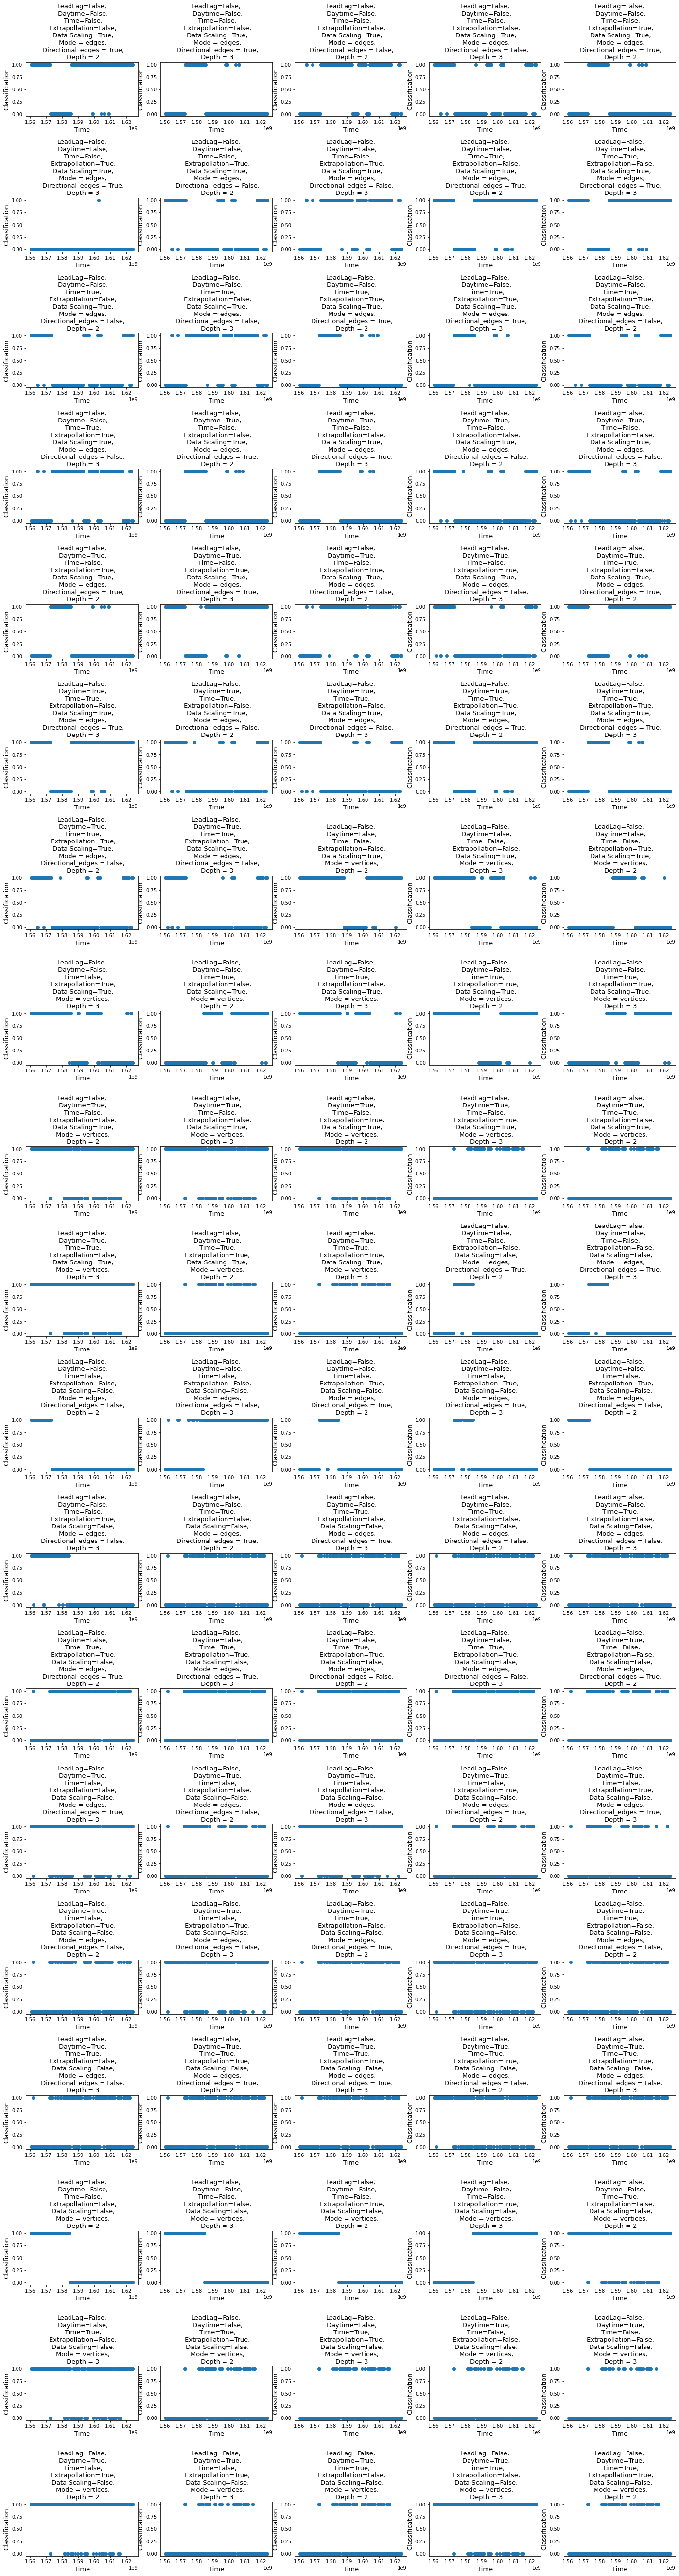

, Length=20, Spacing = 3


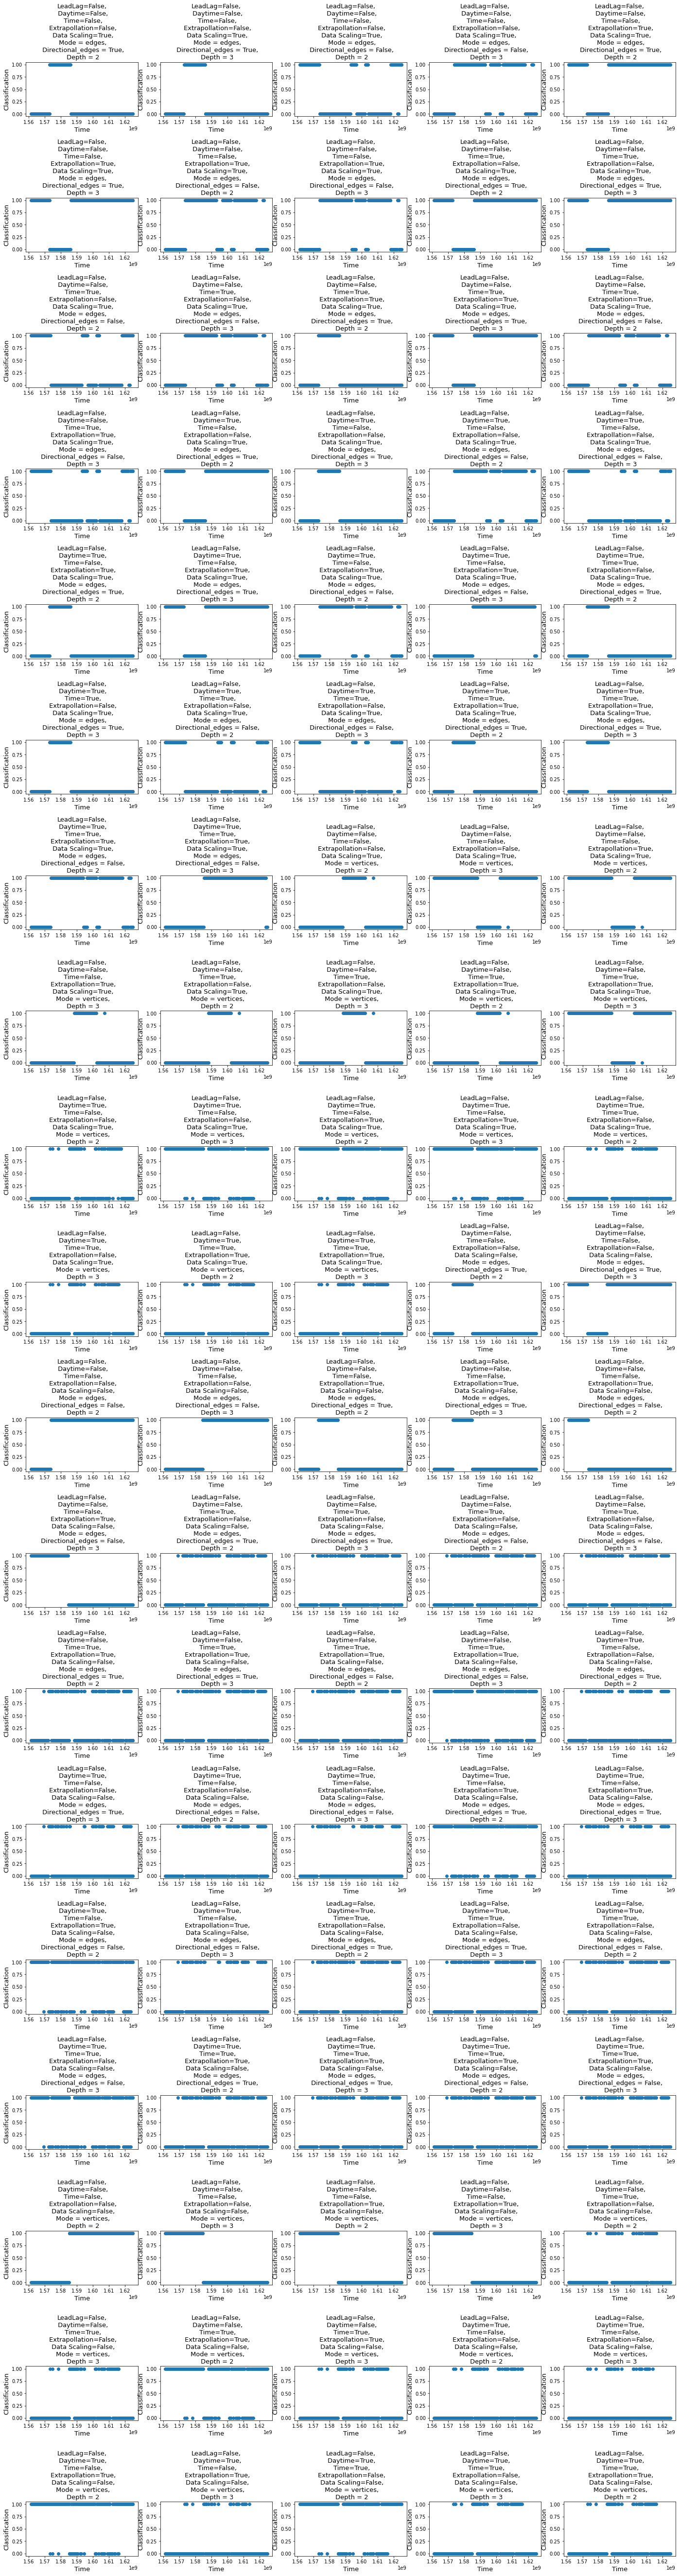

In [15]:
fontsize=13
n_subplots_per_row = 5 
for key in lockdown_labels_vs_hyperparameters.keys():
    print(key)
    labels = lockdown_labels_vs_hyperparameters[key]
    timestamps = lockdown_timestamps_vs_hyperparameters[key]
    n_rows = int(len(labels.keys()) / n_subplots_per_row)
    fig, ax = plt.subplots(n_rows, n_subplots_per_row, figsize=(13.5, n_rows * 2.0), squeeze=True)
    for key_, ax in zip(labels.keys(), ax.flatten()):
        ax.scatter(timestamps[key_], labels[key_])
        ax.set_title(key_.replace(",", ",\n"), fontsize=fontsize)
        ax.set_xlabel('Time', fontsize=fontsize)
        ax.set_ylabel('Classification', fontsize=fontsize)
        #ax.tick_params(axis='both', which='major', labelsize=fontsize)
        #ax.tick_params(axis='both', which='minor', labelsize=fontsize)
        #plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

    plt.subplots_adjust(hspace = 1.5, top = 2, right = 1.5)
    plt.show()


As we can clearly see, some combinations of hyperparameters fail to produce meaningful results. However there are 2 change points consistently detected with some hyperparameters. These correspond to the dates when UK lockdown policy has been significantly changed, as expected.

In [16]:
#Change points detected
print(datetime.fromtimestamp(1585636381))
print(datetime.fromtimestamp(1573453328))

2020-03-31 06:33:01
2019-11-11 06:22:08


# Clustering of airports suspected to be involved in a transfer of troops between Russia and Libya

The methodology here is identical to the one used to detect lockdowns in UK

Airports investigated for malicious activity:

LTFM, OSDI, HLZN, DRRN, OJAI, LTBA, HLLS, EBOS, LMML, DTTX, HLKF, HLMS, HLLB, HEBA, DTTA

We can only investigate few of those airports at any given time due to dimensionality issues.

In [17]:
hyperparameters.observed = tuple(["LTFM", "OSDI", "HLZN", "DRRN", "EBOS", "LMML", "DTTX"])
query2= '''SELECT origin_icao, date, time, event, flight_id 
          FROM Flights
          WHERE destination_icao IN {} AND origin_icao IN {} AND event = 'takeoff'  AND date < '2020-04-01'
          UNION
          SELECT destination_icao, date, time, event, flight_id 
          FROM Flights
          WHERE destination_icao IN {} AND origin_icao IN {} AND event = 'landed' AND date < '2020-04-01' '''.format(*([hyperparameters.observed] * 4) )


conn = sqlite3.connect("file:flights.db?nolock=1", uri=True)
events2 = pd.read_sql_query(query2, conn)
conn.close()

In [18]:
def datetime_convert(row):
    date = row['date']
    time = row['time']
    date = date[2:]
    date_time = date + " " + time
    date_time_obj = datetime.strptime(date_time, '%y-%m-%d %H:%M:%S')
    return int(round(date_time_obj.timestamp()))

events2['timestamp'] = events2.apply(lambda row: datetime_convert(row), axis = 1)
events2 = events2[['origin_icao', 'timestamp', "event", "flight_id"]]
events2 = events2.rename(columns = {'origin_icao': 'icao'})
events2 = events2.rename(columns = {'flight_id': 'id'})

events2 = events2.sort_values("timestamp")

In [19]:
hyperparameters.observed = tuple(["LTFM", "OSDI", "HLZN", "DRRN", "EBOS", "LMML", "DTTX"])
calculate_signatures_by_hyperparameters(events2, CONFLICT_SIGNATURES_PATH)

calculating signatures
................................

In [20]:
conflict_labels_vs_hyperparameters = {}
conflict_timestamps_vs_hyperparameters = {}
for stream_spacing in [3]:
    for stream_length in [10, 20]:
        hyperkey = ', Length=' + str(stream_length) + ', Spacing = '+ str(stream_spacing)
        labels = {}
        timestamps = {}  
        for scaling in [True, False]:
            
            for mode in ["edges", "vertices"]:
                for param_combination in itertools.product(*([[False, True]] * 3)): 
                    if mode == "vertices":
                        timestamps_key = 'LeadLag=False, Daytime={}, Time={}, Extrapollation={}'.format(*param_combination)+', Data Scaling={}'.format(scaling) + hyperkey  + ', Mode = ' + mode
                        for depth in [2, 3]:
                            file_key = timestamps_key + ', Depth = ' + str(depth)
                            key = 'LeadLag=False, Daytime={}, Time={}, Extrapollation={}'.format(*param_combination)+', Data Scaling={}'.format(scaling)+ ', Mode = ' + mode + ', Depth = ' + str(depth)
                            with open(CONFLICT_SIGNATURES_PATH.replace('key', timestamps_key + " TIMESTAMPS"), 'rb') as f_timestamps:
                                with open(CONFLICT_SIGNATURES_PATH.replace('key', file_key), 'rb') as f_signatures:
                                    signatures = pickle.load(f_signatures)
                                    timestamps[key] = pickle.load(f_timestamps)
                                    labels[key] = clustering.kmeans(signatures)
                    else:
                        for directional_edges in [True, False]:
                            timestamps_key = 'LeadLag=False, Daytime={}, Time={}, Extrapollation={}'.format(*param_combination)+', Data Scaling={}'.format(scaling)+ hyperkey  + ', Mode = ' + mode + ', Directional_edges = {}'.format(directional_edges)
                            for depth in [2, 3]:
                                file_key = timestamps_key   + ', Depth = ' + str(depth)
                                key = 'LeadLag=False, Daytime={}, Time={}, Extrapollation={}'.format(*param_combination)+', Data Scaling={}'.format(scaling)+ ', Mode = ' + mode + ', Directional_edges = {}'.format(directional_edges) + ', Depth = ' + str(depth)
                                with open(CONFLICT_SIGNATURES_PATH.replace('key', timestamps_key + " TIMESTAMPS"), 'rb') as f_timestamps:
                                    with open(CONFLICT_SIGNATURES_PATH.replace('key', file_key), 'rb') as f_signatures:
                                        signatures = pickle.load(f_signatures)
                                        timestamps[key] = pickle.load(f_timestamps)
                                        labels[key] = clustering.kmeans(signatures)
        conflict_labels_vs_hyperparameters[hyperkey] = labels
        conflict_timestamps_vs_hyperparameters[hyperkey] = timestamps

, Length=10, Spacing = 3


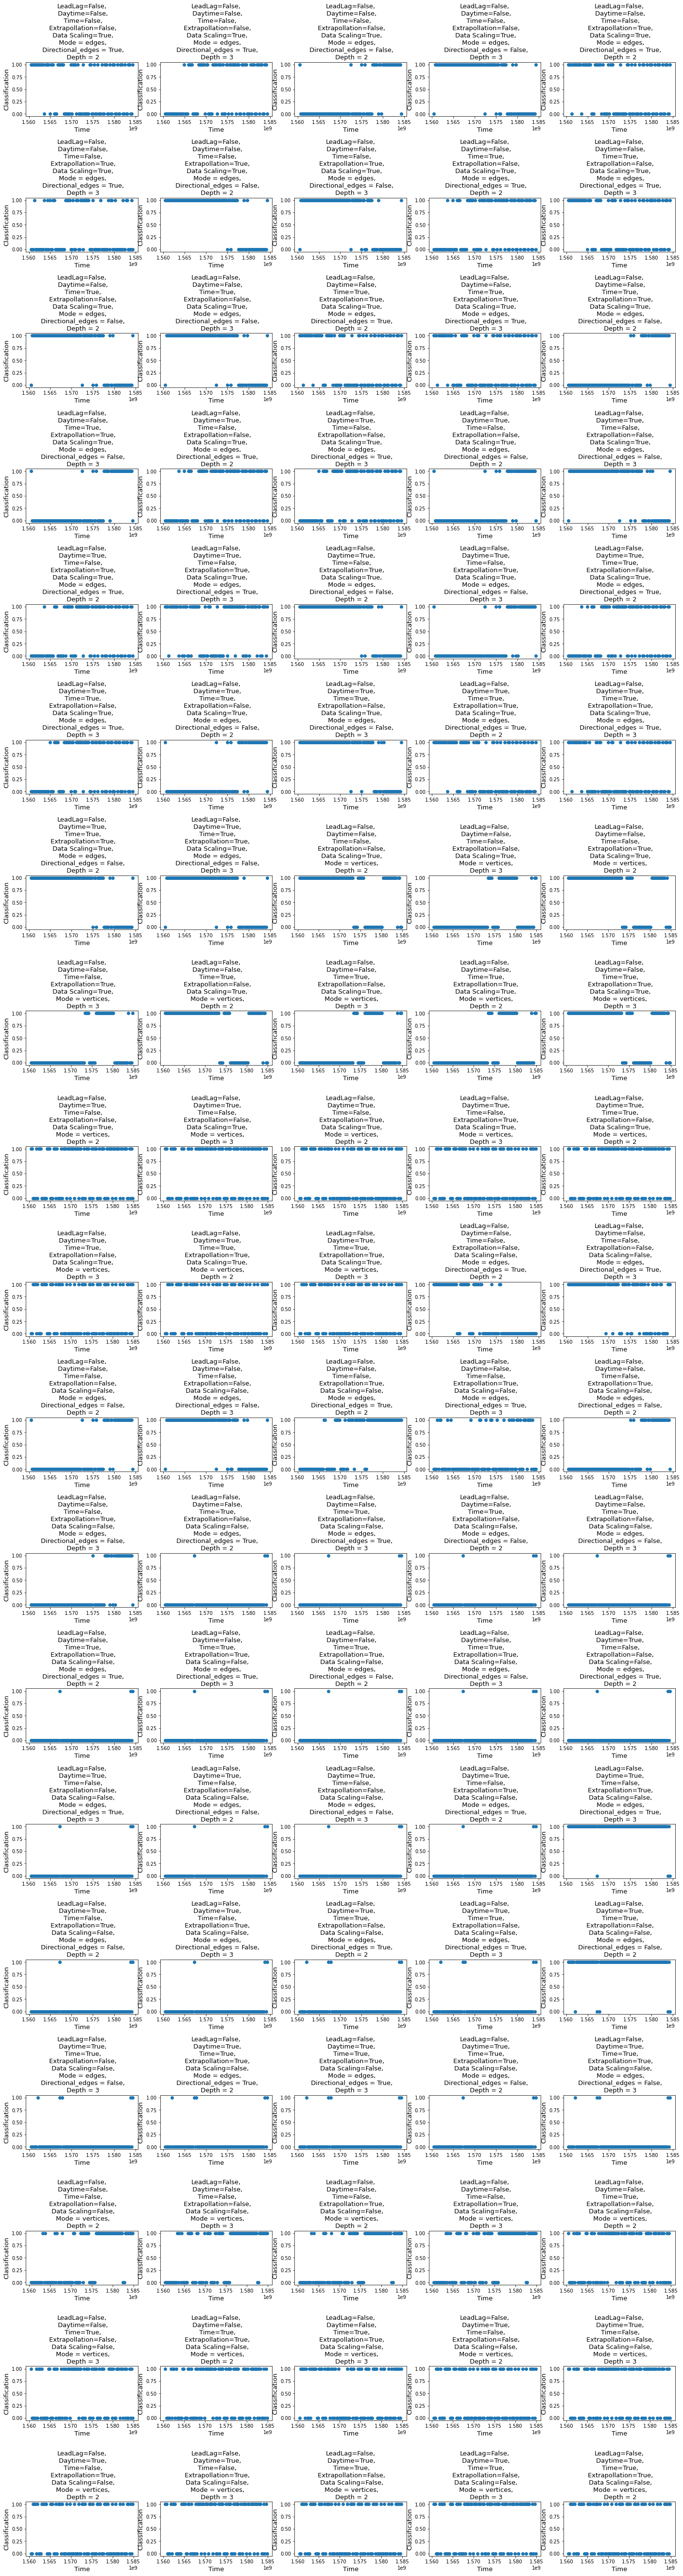

, Length=20, Spacing = 3


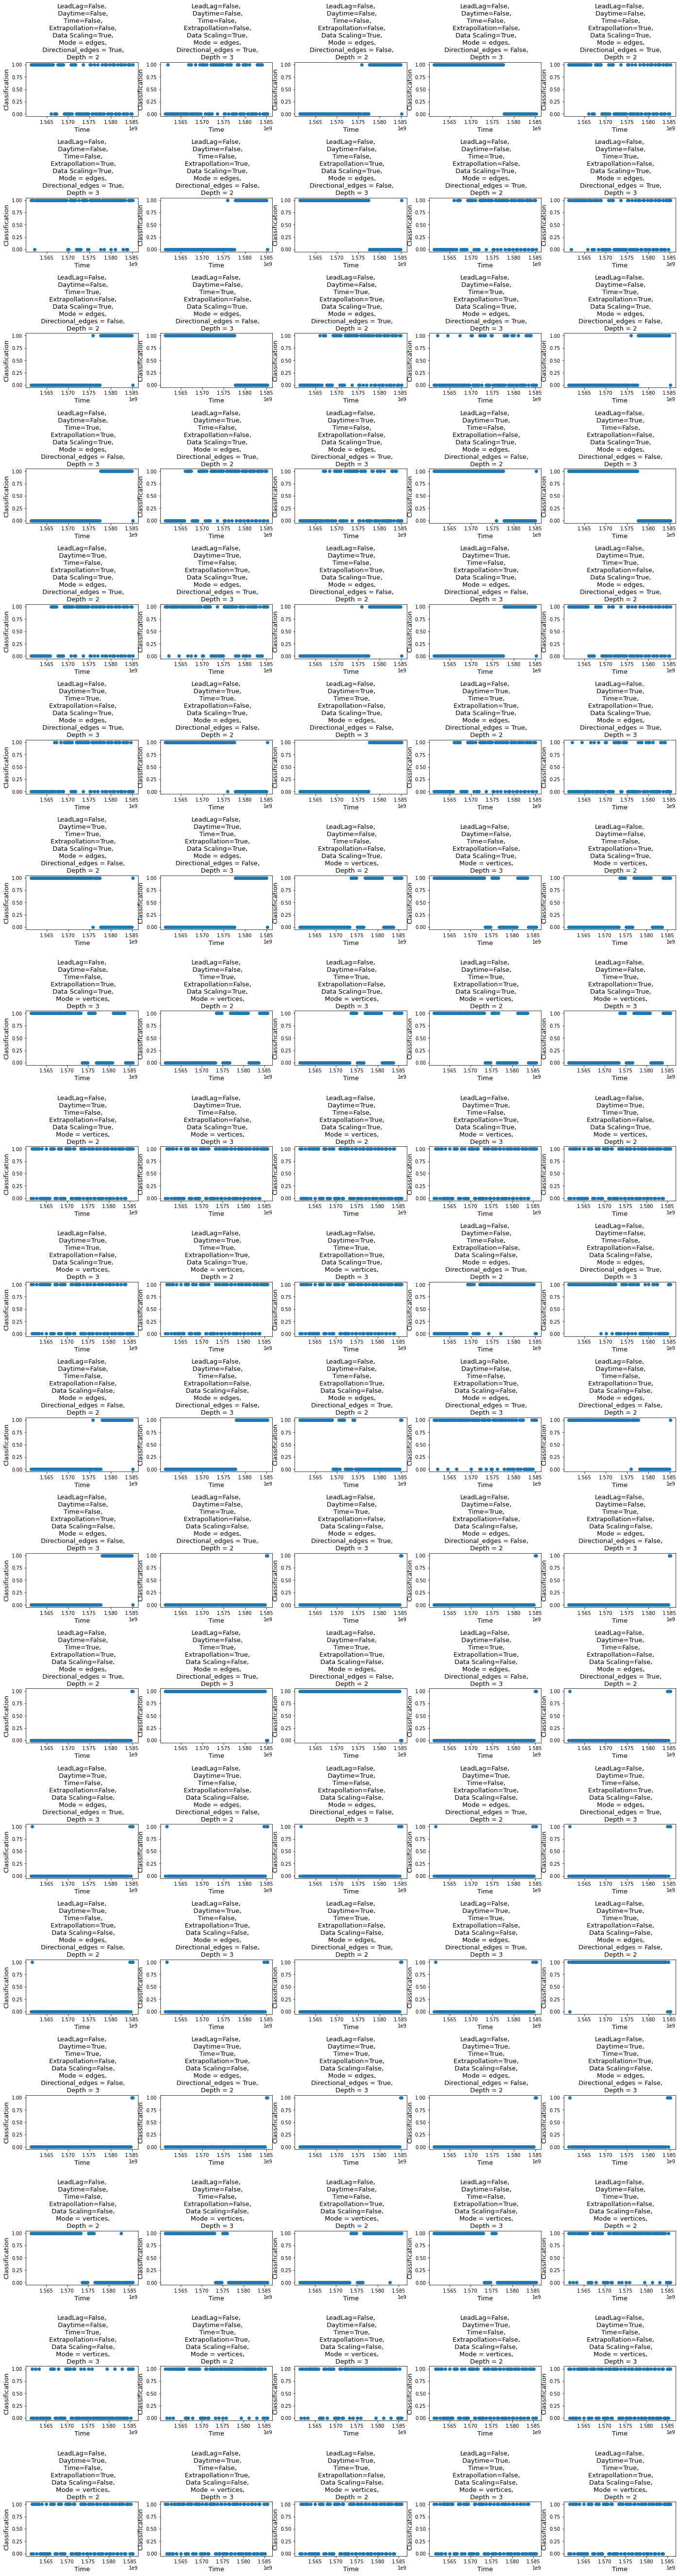

In [21]:
fontsize=13
n_subplots_per_row = 5 
for key in conflict_labels_vs_hyperparameters.keys():
    print(key)
    labels = conflict_labels_vs_hyperparameters[key]
    timestamps = conflict_timestamps_vs_hyperparameters[key]
    n_rows = int(len(labels.keys()) / n_subplots_per_row)
    fig, ax = plt.subplots(n_rows, n_subplots_per_row, figsize=(13.5, n_rows * 2.0), squeeze=True)
    for key_, ax in zip(labels.keys(), ax.flatten()):
        ax.scatter(timestamps[key_], labels[key_])
        ax.set_title(key_.replace(",", ",\n"), fontsize=fontsize)
        ax.set_xlabel('Time', fontsize=fontsize)
        ax.set_ylabel('Classification', fontsize=fontsize)
        #ax.tick_params(axis='both', which='major', labelsize=fontsize)
        #ax.tick_params(axis='both', which='minor', labelsize=fontsize)
        #plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

    plt.subplots_adjust(hspace = 1.5, top = 2, right = 1.5)
    plt.show()

Again, here we can see that most hyperparameter combinations fail to produce significant results, but the ones that produce a clear change point detect a date consistent with when Russian involvment is believed to have started.

In [22]:
# Detected change points
print(datetime.fromtimestamp(1577604863))
print(datetime.fromtimestamp(1573186141))

2019-12-29 07:34:23
2019-11-08 04:09:01


# Using dummy data

As seen above, the results produced by analysing real life data are messy, depend heavily on use of hyperparameters and can only be evaluated subjectively with how "clean" the change point is and how well it corresponds to when the anomalous time period is believed to have started. Hence, we will use dummy data to analyse performance of our vectorisation with off-the-shelf anomaly detection algorithms on a labeled data with known anomalies.

To do so, we will compute subpaths and signatures across different combinations of hyperparameters for our data and plot ROC curve for each of those, using area under the ROC curve as the performance metric. We will also test algorithm on both data with 3 kind of anomaly and with 1 kind, under the conjecture that with fewer types of anomalies it will be easier to detect them.

## Data with all 3 kinds of anomalies with KNN anomaly detection algorithm


In [23]:
hyperparameters.observed = tuple([np.int_(0), np.int_(1), np.int_(2), np.int_(3), np.int_(4)])
calculate_signatures_by_hyperparameters(dummy_events, DUMMY_SIGNATURES_PATH, dummy_anomalous_IDs)
print()
calculate_signatures_by_hyperparameters(dummy_clean_events, DUMMY_CLEAN_SIGNATURES_PATH)

calculating signatures
................................calculating signatures
................................

In [24]:
knn_prediction_vs_hyperparameters = {}
labels_vs_hyperparameters = {}

for stream_spacing in [3]:
    for stream_length in [10]:
        knn_prediction ={}
        knn_labels = {}
        for scaling in [True, False]:
            for mode in ["edges", "vertices"]:
                for param_combination in itertools.product(*([[False, True]] * 3)):
                    key = 'LeadLag=False, Daytime={}, Time={}, Extrapollation={}'.format(*param_combination)+', Data Scaling={}'.format(scaling) + ', Length=' + str(stream_length) + ', Spacing = ' + str(stream_spacing) + ', Mode = ' + mode 
                    print('.', end='')
                    for depth in [2, 3]:
                        if mode == "edges":
                            for directional_edges in [True, False]:
                                hyperparameters.directional_edges = directional_edges
                                key_ = key + ', Directional_edges = {}'.format(directional_edges) 
                                key__ = key_ + ', Depth = ' + str(depth)
                                with open(DUMMY_SIGNATURES_PATH.replace('key', key__), 'rb') as f_sig:
                                    with open(DUMMY_SIGNATURES_PATH.replace('key', key_ + ' LABELS'), 'rb') as f_label:
                                        signatures = pickle.load(f_sig)
                                        labels = pickle.load(f_label)
                                        pred = outlier_calc.knn(signatures, hyperparameters)
                                        knn_prediction[key_] = pred
                                        knn_labels[key_] = labels
                        else:
                            key_ = key + ', Depth = ' + str(depth)
                            with open(DUMMY_SIGNATURES_PATH.replace('key', key_), 'rb') as f_sig:
                                with open(DUMMY_SIGNATURES_PATH.replace('key', key + ' LABELS'), 'rb') as f_label:
                                    signatures = pickle.load(f_sig)
                                    labels = pickle.load(f_label)
                                    pred = outlier_calc.knn(signatures, hyperparameters)
                                    knn_prediction[key_] = pred
                                    knn_labels[key_] = labels

        key2 = "Stream length = {} days".format(stream_length)
        knn_prediction_vs_hyperparameters[key2] =  knn_prediction
        labels_vs_hyperparameters[key2] = knn_labels

................................

Stream length = 10 days


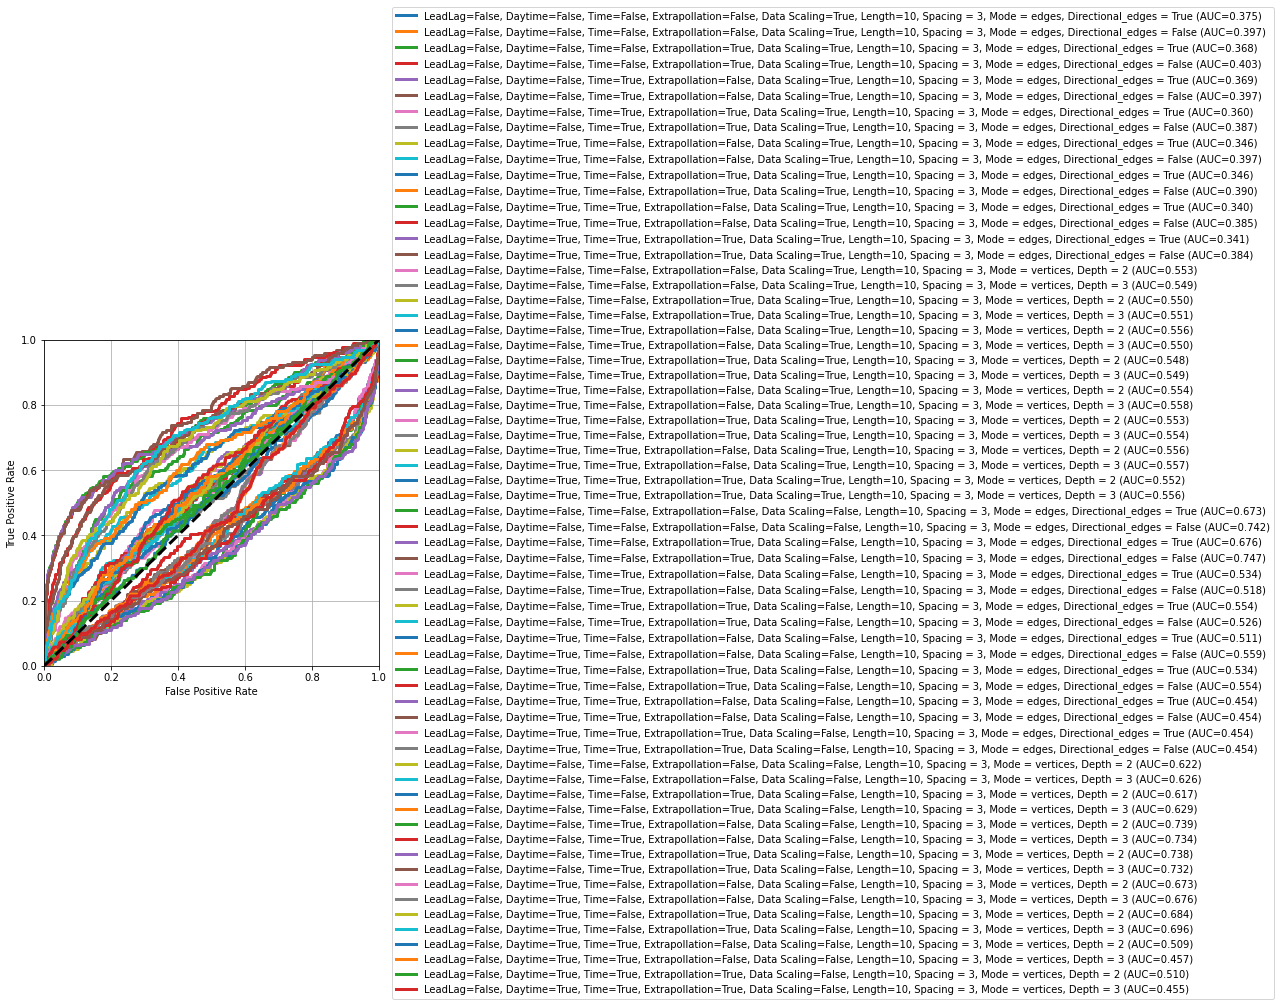

In [25]:
for key in knn_prediction_vs_hyperparameters.keys():
    print(key)
    outlier_calc.plot_roc_curve(knn_prediction_vs_hyperparameters[key], labels_vs_hyperparameters[key])
    

## Data with 1 kind of anomalies with KNN anomaly detection algorithm

In [26]:
from generator import generate_data_only_chaining
generate_data_only_chaining()

In [27]:
dummy_anomalous_events_labels2 = pd.read_csv('data_chaining_only_anomaly_labels.csv')
dummy_anomalous_IDs2 = set(dummy_anomalous_events_labels2['id'].values.tolist())
dummy_events2 = pd.read_csv('data_chaining_only.csv')

In [28]:
hyperparameters.observed = tuple([np.int_(0), np.int_(1), np.int_(2), np.int_(3), np.int_(4)])
calculate_signatures_by_hyperparameters(dummy_events2, DUMMY_SIGNATURES_PATH2, dummy_anomalous_IDs2)


calculating signatures
................................

In [29]:
knn_prediction_vs_hyperparameters2 = {}
labels_vs_hyperparameters2 = {}

for stream_spacing in [3]:
    for stream_length in [10]:
        knn_prediction ={}
        knn_labels = {}
        for scaling in [True, False]:
            for mode in ["edges", "vertices"]:
                for param_combination in itertools.product(*([[False, True]] * 3)):
                    key = 'LeadLag=False, Daytime={}, Time={}, Extrapollation={}'.format(*param_combination)+', Data Scaling={}'.format(scaling) + ', Length=' + str(stream_length) + ', Spacing = ' + str(stream_spacing) + ', Mode = ' + mode 
                    print('.', end='')
                    for depth in [2, 3]:
                        if mode == "edges":
                            for directional_edges in [True, False]:
                                hyperparameters.directional_edges = directional_edges
                                key_ = key + ', Directional_edges = {}'.format(directional_edges) 
                                key__ = key_ + ', Depth = ' + str(depth)
                                with open(DUMMY_SIGNATURES_PATH2.replace('key', key__), 'rb') as f_sig:
                                    with open(DUMMY_SIGNATURES_PATH2.replace('key', key_ + ' LABELS'), 'rb') as f_label:
                                        
                                        signatures = pickle.load(f_sig)
                                        labels = pickle.load(f_label)
                                        pred = outlier_calc.knn(signatures, hyperparameters)
                                        knn_prediction[key_] = pred
                                        knn_labels[key_] = labels
                        else:
                            key_ = key + ', Depth = ' + str(depth)
                            with open(DUMMY_SIGNATURES_PATH2.replace('key', key_), 'rb') as f_sig:
                                with open(DUMMY_SIGNATURES_PATH2.replace('key', key + ' LABELS'), 'rb') as f_label:
                                    signatures = pickle.load(f_sig)
                                    labels = pickle.load(f_label)
                                    pred = outlier_calc.knn(signatures, hyperparameters)
                                    knn_prediction[key_] = pred
                                    knn_labels[key_] = labels

        key2 = "Stream length = {} days".format(stream_length)
        knn_prediction_vs_hyperparameters2[key2] =  knn_prediction
        labels_vs_hyperparameters2[key2] = knn_labels

................................

Stream length = 10 days


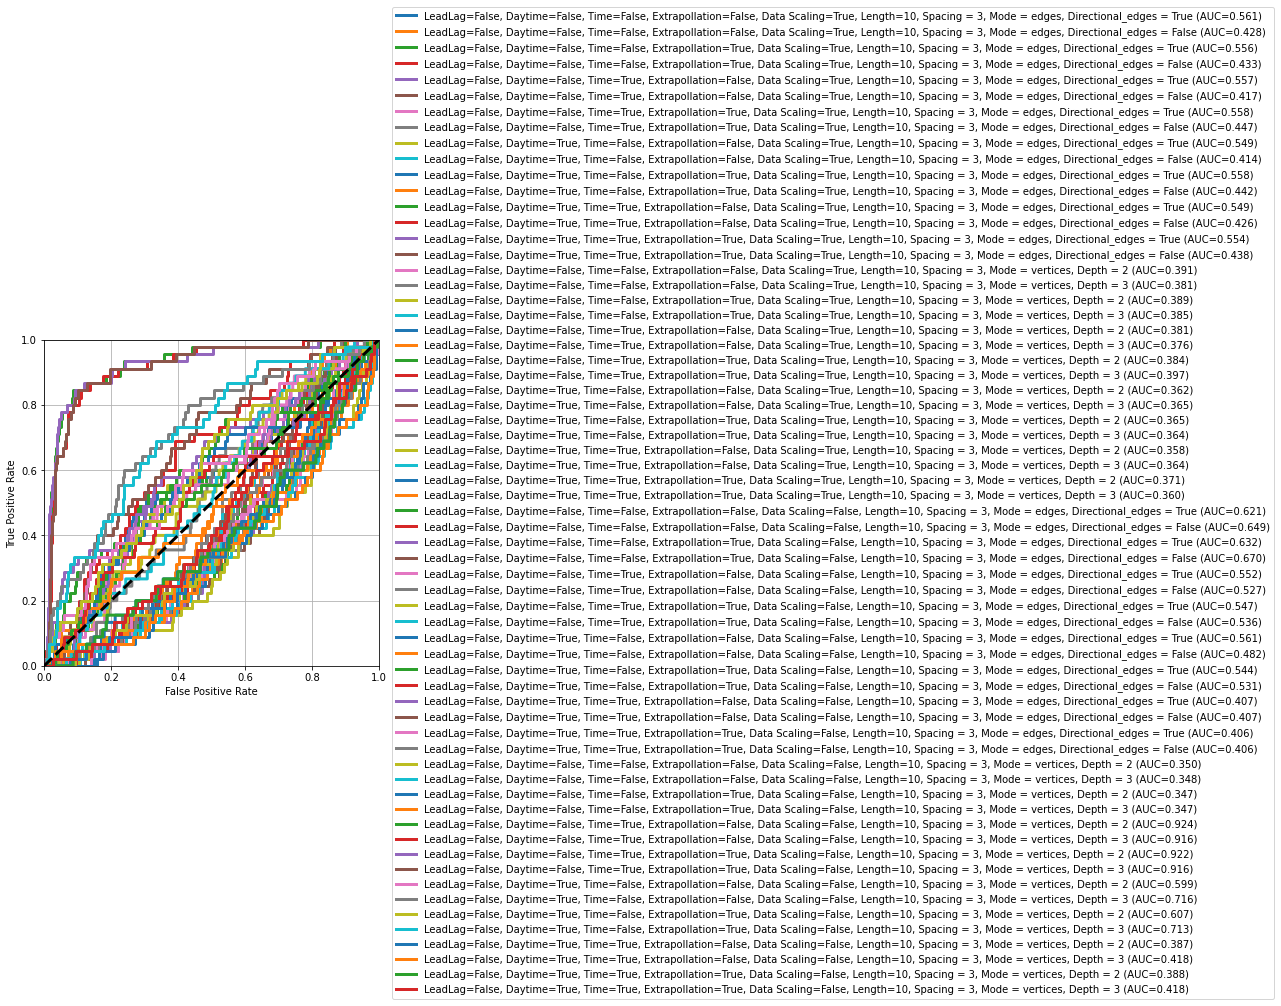

In [30]:
for key in knn_prediction_vs_hyperparameters2.keys():
    print(key)
    outlier_calc.plot_roc_curve(knn_prediction_vs_hyperparameters2[key], labels_vs_hyperparameters2[key])
    

## Data with 1 kind of anomalies with conformance score anomaly detection algorithm

You can read mroe about conformance score in the following paper : https://arxiv.org/abs/2006.03487v1

The code generating the scores is taken directly from that paper. 

In [40]:
conformance_prediction_vs_hyperparameters = {}
conformance_labels_vs_hyperparameters = {}

for stream_spacing in [3]:
    for stream_length in [10]:
        conformance_prediction ={}
        conformance_labels = {}
        for scaling in [False]:
            for mode in ["edges", "vertices"]:
                for param_combination in itertools.product(*([[False, True]] * 2)):
                    key = 'LeadLag=False, Daytime={}, Time={}, Extrapollation=False'.format(*param_combination)+', Data Scaling={}'.format(scaling) + ', Length=' + str(stream_length) + ', Spacing = ' + str(stream_spacing) + ', Mode = ' + mode 
                    if mode == "edges":
                        for directional_edges in [True, False]:
                            hyperparameters.directional_edges = directional_edges
                            key_ = key + ', Directional_edges = {}'.format(directional_edges)
                            with open(DUMMY_SIGNATURES_PATH2.replace('key', key_  + " STREAMS"), 'rb') as f_streams:
                                with open(DUMMY_SIGNATURES_PATH2.replace('key', key_ + ' LABELS'), 'rb') as f_label:
                                    with open(DUMMY_CLEAN_SIGNATURES_PATH.replace('key', key_  + " STREAMS"), 'rb') as f_clean_sig:
                                        clean_streams = pickle.load(f_clean_sig)
                                        streams = pickle.load(f_streams)
                                        labels = pickle.load(f_label)
                                        for depth in [2]:
                                            key__ = key_ + ', Depth = ' + str(depth) 
                                            pred = variance(streams, clean_streams, depth) 
                                            conformance_prediction[key_] = pred
                                            conformance_labels[key_] = labels
                    else:
                        key_ = key
                        with open(DUMMY_SIGNATURES_PATH2.replace('key', key_ + " STREAMS"), 'rb') as f_streams:
                            with open(DUMMY_SIGNATURES_PATH2.replace('key', key_ + ' LABELS'), 'rb') as f_label:
                                with open(DUMMY_CLEAN_SIGNATURES_PATH.replace('key', key_ + " STREAMS"), 'rb') as f_clean_streams:
                                    clean_streams = pickle.load(f_clean_streams)
                                    streams = pickle.load(f_streams)
                                    labels = pickle.load(f_label)
                                    for depth in [2]:
                                        key__ = key_ + ', Depth = ' + str(depth) 
                                        pred = variance(streams, clean_streams, depth)
                                        conformance_prediction[key_] = pred
                                        conformance_labels[key_] = labels

        key2 = "Stream length = {} days".format(stream_length)
        conformance_prediction_vs_hyperparameters[key2] =  conformance_prediction
        conformance_labels_vs_hyperparameters[key2] = conformance_labels

Computing variances: 100%|██████████| 869/869 [00:31<00:00, 27.49it/s]


Stream length = 10 days


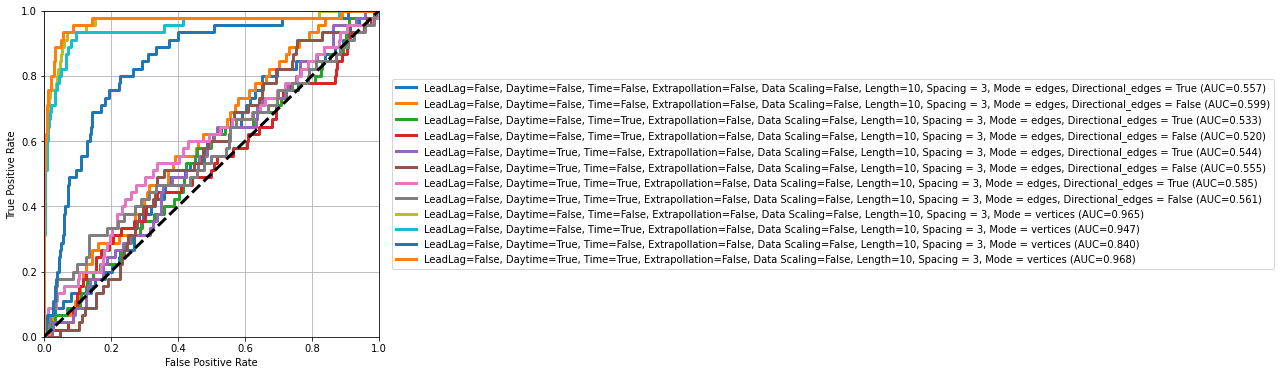

In [41]:
for key in conformance_prediction_vs_hyperparameters.keys():
    print(key)
    outlier_calc.plot_roc_curve(conformance_prediction_vs_hyperparameters[key], conformance_labels_vs_hyperparameters[key])
    